# Multinomial Naive Bayes Spam Classifier

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Problem Set: Spam Filtering with Multinomial Naive Bayes Classifiers

## What to expect

1. Representing text as numerical or count data
2. Reading a text corpus into a pandas DataFrame
3. Vectorizing the dataset with CountVectorizer
4. Building and evaluating a Spam Classifier
5. Examining a model for further insight
6. Tuning the vectorizer
7. Tuning the Laplacian Correction factor 

## Part 1: Representing text as numerical data

In [2]:
# example text for model training
simple_train = ['hello how are you', 'Hello are you there', 'why hello there']

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

We will use the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to "convert a text corpus into a sparse matrix of word or token counts":

In [3]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [4]:
# learn the 'vocabulary' of the training data (occurs in-place)
# Use the fit() method of the CountVectorizer on simple_train
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [5]:
# examine the fitted vocabulary
vect.get_feature_names()

['are', 'hello', 'how', 'there', 'why', 'you']

In [6]:
# using the transform() method, transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)

In [7]:
# we can also convert a sparse matrix to a dense matrix
# using the toarray() method
simple_train_dtm.toarray()

array([[1, 1, 1, 0, 0, 1],
       [1, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 0]], dtype=int64)

In [8]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,are,hello,how,there,why,you
0,1,1,1,0,0,1
1,1,1,0,1,0,1
2,0,1,0,1,1,0


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

In [9]:
# check the type of the document-term matrix
type(simple_train_dtm)

scipy.sparse.csr.csr_matrix

In [10]:
# examine the sparse matrix contents
print(simple_train_dtm)

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 3)	1
  (1, 5)	1
  (2, 1)	1
  (2, 3)	1
  (2, 4)	1


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.

In [14]:
# example text for model testing
simple_test = ["hello world apples"]

In [15]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 0, 0, 0, 0]], dtype=int64)

In [16]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

,are,hello,how,there,why,you
0,0,1,0,0,0,0


## Part 3: Reading a text-based dataset into pandas

In [23]:
# read file into a pandas DataFrame
# use names=['label', 'location','message'] as a parameter in the read_csv() method 
# finally, drop the irrelevant location columns and also rows with nan values
path = 'data/spam_ham.csv'
spam_ham = pd.read_csv(path, names=['label', 'location','message'], skiprows=[0])

In [24]:
# examine the shape
spam_ham.shape

(31161, 3)

In [25]:
# examine the first 10 rows
spam_ham.head(10)

,label,location,message
0,spam,data/000/001,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY $...
1,spam,data/000/002,Academic Qualifications available from prestig...
2,ham,data/000/003,Greetings all. This is to verify your subscrip...
3,spam,data/000/004,try chauncey may conferred the luscious not co...
4,ham,data/000/005,"It's quiet. Too quiet. Well, how about a straw..."
5,ham,data/000/006,It's working here. I have departed almost tota...
6,spam,data/000/008,The OIL sector is going crazy. This is our wee...
7,spam,data/000/009,Little magic. Perfect weekends.http://othxu.rz...
8,ham,data/000/010,Greetings all. This is a mass acknowledgement ...
9,spam,data/000/011,"Hi, L C P A X V V e I r m a A I v A o b n L A ..."


In [26]:
# examine the class distribution
spam_ham['label'].value_counts()

spam    19362
ham     11799
Name: label, dtype: int64

In [32]:
# convert label to a numerical variable
# using the map() function or Scikit-Learn's LabelEncoder
# spam_ham['label'].map(lambda x: 1 if x == 'spam' else 0)
from sklearn.preprocessing import LabelEncoder
spam_ham['label'] = LabelEncoder().fit_transform(spam_ham['label'])

In [33]:
# check that the conversion worked using the head() method
spam_ham.head()

,label,location,message
0,1,data/000/001,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY $...
1,1,data/000/002,Academic Qualifications available from prestig...
2,0,data/000/003,Greetings all. This is to verify your subscrip...
3,1,data/000/004,try chauncey may conferred the luscious not co...
4,0,data/000/005,"It's quiet. Too quiet. Well, how about a straw..."


In [34]:
# This is to define the features and labels for the CountVectorizer
X = spam_ham['message'].fillna('')
y = spam_ham['label']
print(X.shape)
print(y.shape)

(31161,)
(31161,)


In [35]:
# split X and y into training and testing sets
# using the train_test_split() function
# Don't forget to stratify by y and set a random_state value
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23370,)
(7791,)
(23370,)
(7791,)


## Part 4: Vectorizing the dataset

In [36]:
# instantiate a new count vectorizer
vect = CountVectorizer()

In [37]:
# learn training data vocabulary, then use it to create a document-term matrix
# using the fit_transform() method
# assign X_train_dtm to the output
X_train_dtm = vect.fit_transform(X_train)

In [38]:
# examine the fitted vocabulary
vect.get_feature_names()[0:10]

['00',
 '000',
 '0000',
 '000000',
 '0000000',
 '00000000',
 '000000000',
 '00000000000000',
 '0000000000status',
 '00000000message']

In [39]:
# examine the document-term matrix
X_train_dtm

<23370x155840 sparse matrix of type '<class 'numpy.int64'>'
	with 2303897 stored elements in Compressed Sparse Row format>

In [40]:
# transform testing data into a document-term matrix
# using the transform() method
X_test_dtm = vect.transform(X_test)
X_test_dtm[0:10]

<10x155840 sparse matrix of type '<class 'numpy.int64'>'
	with 1428 stored elements in Compressed Sparse Row format>

## Part 5: Building and evaluating a Spam Classifier

We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [41]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [42]:
# train the model using X_train_dtm
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
# make predictions for X_test_dtm
preds = nb.predict(X_test_dtm)

In [44]:
# calculate balanced accuracy of class predictions
from sklearn import metrics
metrics.balanced_accuracy_score(y_test, preds)

0.9849416880529657

In [45]:
# Generate the predicted probabilities for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([5.4042997e-106, 1.0000000e-001, 2.0000000e-001, 3.0000000e-001,
        4.0000000e-001, 5.0000000e-001, 6.0000000e-001, 7.0000000e-001,
        8.0000000e-001, 9.0000000e-001, 1.0000000e+000]),
 <a list of 10 Patch objects>)

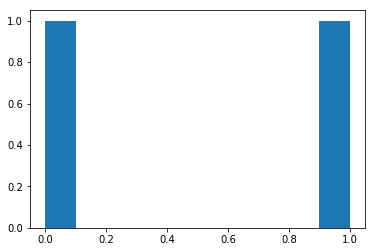

In [46]:
# Plotting the histogram of probabilities..
# What does this mean? Explain.
hist(y_pred_prob[0, :])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([9.79446291e-04, 1.00783557e-01, 2.00587668e-01, 3.00391779e-01,
        4.00195889e-01, 5.00000000e-01, 5.99804111e-01, 6.99608221e-01,
        7.99412332e-01, 8.99216443e-01, 9.99020554e-01]),
 <a list of 10 Patch objects>)

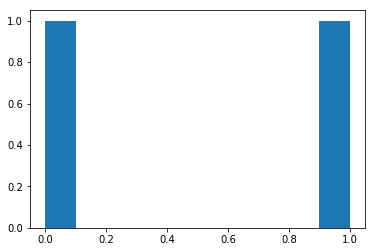

In [47]:
hist(y_pred_prob[1, :])

## Part 7: Examining the vectorized dataset and spam classifier

We will examine the **count vectorizer** and **trained spam classifier** to calculate and approximate **spam ratio of each token**.

In [48]:
# store the vocabulary of X_train with get_feature_names of the vect() object
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

155840

In [49]:
# examine the first 20 tokens
print(X_train_tokens[0:20])

['00', '000', '0000', '000000', '0000000', '00000000', '000000000', '00000000000000', '0000000000status', '00000000message', '00000000x', '00000001', '00000001content', '00000001irdecode', '00000004', '00000010', '00000010pwm', '00000011', '0000001196', '00000049']


In [50]:
# examine the last 20 tokens
print(X_train_tokens[-20:])

['ｍ子様セーリングクルーザーをお持ちで', 'ｍ字開脚オナニーを机の下から盗撮', 'ｍａｉｌでのサポートは２４時間対応です', 'ｎ藤', 'ｏｌ', 'ｐｃ', 'ｐｃから簡単プロフィール作成', 'ｓクラス専門店', 'ｓ子様秘密が条件で', 'ｓｅｘを求めている', 'ｓｅｘを求めているのです', 'ｓｍ', 'ｔ165', 'ｔバックは', 'ｔバックはいていたらおならが左右に分散するのでなんか変な感じですけどね', 'ｔバックを購入しました', 'ｔ島', 'ｔ谷', 'ｗ６２', 'ｙ里様お互いがくつろげるような']


In [51]:
# with the feature_count_ attribute,
# MultinomialNB counts the number of times each token appears in each class
nb.feature_count_

array([[1.873e+03, 4.070e+02, 3.560e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.570e+03, 5.395e+03, 2.000e+00, ..., 1.000e+00, 4.000e+00,
        1.000e+00]])

In [52]:
# number of times each token appears across all HAM messages
ham_token_count = nb.feature_count_[0, :]
ham_token_count

array([1873.,  407.,  356., ...,    0.,    0.,    0.])

In [53]:
# number of times each token appears across all SPAM messages
spam_token_count = nb.feature_count_[1, :]
spam_token_count

array([3.570e+03, 5.395e+03, 2.000e+00, ..., 1.000e+00, 4.000e+00,
       1.000e+00])

In [57]:
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame()
tokens['token'] = X_train_tokens
tokens['ham_count'] = ham_token_count
tokens['spam_count'] = spam_token_count
tokens.head()

,token,ham_count,spam_count
0,00,1873.0,3570.0
1,000,407.0,5395.0
2,0000,356.0,2.0
3,000000,44.0,60.0
4,0000000,1.0,0.0


In [58]:
# examine 5 random DataFrame rows
# using the sample() method
tokens.sample(5, random_state=42)

,token,ham_count,spam_count
150009,youall,2.0,3.0
154962,男性様にご理解を頂く為,0.0,1.0
62813,fulfill,5.0,49.0
90340,mieke,2.0,0.0
13312,6003another,1.0,0.0


In [59]:
# Naive Bayes counts the number of observations in each class
# with the class_count_ attribute
nb.class_count_

array([ 8849., 14521.])

In [61]:
# add 1 to ham and spam counts to avoid dividing by 0
# so that we can calculate the spam ratio of each token
tokens['ham_ratio'] = (tokens['ham_count'] + 1) / tokens['ham_count'].sum()
tokens['spam_ratio'] = (tokens['spam_count'] + 1)/ tokens['spam_count'].sum()

In [62]:
# convert the ham and spam counts into ratios
tokens.head()

,token,ham_count,spam_count,ham_ratio,spam_ratio
0,00,1873.0,3570.0,7.519648e-04,1.670082e-03
1,000,407.0,5395.0,1.637149e-04,2.523596e-03
2,0000,356.0,2.0,1.432505e-04,1.403037e-06
3,000000,44.0,60.0,1.805678e-05,2.852842e-05
4,0000000,1.0,0.0,8.025238e-07,4.676789e-07


In [63]:
# calculate the ratio of spam-to-ham for each token
tokens['spam_to_ham_ratio'] = tokens['spam_ratio'] / tokens['ham_ratio']

In [65]:
# examine the DataFrame sorted by spam_to_ham_ratio
tokens.sort_values('spam_to_ham_ratio', ascending=True)

,token,ham_count,spam_count,ham_ratio,spam_ratio,spam_to_ham_ratio
68276,hb,1746.0,0.0,7.010045e-04,4.676789e-07,0.000667
95940,node,1508.0,0.0,6.055042e-04,4.676789e-07,0.000772
38625,cert,1482.0,0.0,5.950714e-04,4.676789e-07,0.000786
67431,handy,1425.0,0.0,5.721995e-04,4.676789e-07,0.000817
95979,nodes,1403.0,0.0,5.633717e-04,4.676789e-07,0.000830
106695,port,1164.0,0.0,4.674701e-04,4.676789e-07,0.001000
95666,nil,3270.0,2.0,1.312528e-03,1.403037e-06,0.001069
101658,output,1069.0,0.0,4.293502e-04,4.676789e-07,0.001089
125685,starship,1055.0,0.0,4.237326e-04,4.676789e-07,0.001104
115100,ribbon,1033.0,0.0,4.149048e-04,4.676789e-07,0.001127


In [ ]:
# look up the spam_ratio for a given token
# Note that the specified token, adobe, can change due to the nature of randomness
tokens.loc['adobe', 'spam_ratio']

## Part 9: Tuning the vectorizer

Currently, we've been using the default parameters of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

In [ ]:
# show default parameters for CountVectorizer
vect

In [ ]:
"I love apples"

In [ ]:
unigrams = ["I", "love", "apples"]

In [ ]:
bigrams = ["I love", "love apples"]

"I love new york", "I love new stuff"

Some parameters that we can tune in the CountVectorizer:

- **stop_words:** string {'english'}, list, or None (default)
    - If 'english', a built-in stop word list for English is used.
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    - If None, no stop words will be used.

- **ngram_range:** tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

- **min_df:** float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

**Guidelines for tuning the CountVectorizer:**

Tasks:
1. From the spam ratios that you've obtained from before, **experiment** by adding more stop words!
2. Play with the df and n-gram parameters.
    * Try using GridSearch on the CountVectorizer!
3. Try to reduce or increase the features and get a better score on the previous model. 
    * Score above a 99.5%? Tell us! :)

## Part 10: Tuning the Laplacian Correction Factor

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> class sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

> Parameters:	
alpha : float, optional (default=1.0)
Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

One of the parameters that we can tune in training a Multinomial Naive Bayes Classifier is the Laplacian Correction Factor.

Tasks:
1. Tweak the correction factor from 0-3 in increments of 0.1, 5, and 10, thus training multiple classifiers.
2. Plot the precision-recall curves for these classifiers to compare and contrast.
3. Explain why the Laplacian Correction Factor is significant. What happens if it's 0?

## Part 11: Compare and Contrast the Difference of Using CountVectorizer vs TF-IDF Vectorizer

Tasks:

1. Train two models of Naive Bayes Classifiers that have the same train and test sets with CountVectorizer and TF-IDF.
2. Explain how TF-IDF works.
2. Which vectorizer works better? Why do you think so?

## References
This practicals notebook is largely based from the Sci-kit Learn Documentation and PyCon 2016.

1. http://scikit-learn.org/stable/modules/feature_extraction.html
2. http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
3. https://www.youtube.com/watch?v=WHocRqT-KkU